In [75]:
import sqlite3
import matplotlib.pyplot as plt
import csv
import time
import os
import re


In [76]:
def clean_header(header):
    # Remplacer les espaces et tirets par des underscores et supprimer les caractères spéciaux
    header = re.sub(r'[^a-zA-Z0-9_]', '', header.replace(' ', '_').replace('-', '_').lower())
    return header

def clean_csv(file_path, cleaned_file_path):
    with open(file_path, 'r', encoding='utf-8') as f, open(cleaned_file_path, 'w', encoding='utf-8', newline='') as cf:
        reader = csv.reader(f)
        writer = csv.writer(cf)

        headers = next(reader)
        headers = [clean_header(header) for header in headers]
        writer.writerow(headers)

        for row in reader:
            # Ignorer les lignes complètement vides
            if not any(row):
                continue
            # Si une ligne a moins de valeurs, la compléter avec des chaînes vides
            if len(row) < len(headers):
                row += [''] * (len(headers) - len(row))
            # Si une ligne a plus de valeurs, la tronquer
            elif len(row) > len(headers):
                row = row[:len(headers)]
            writer.writerow(row)

def create_table_from_csv(file_path, table_name):
    retries = 0
    max_retries = 10
    wait_time = 5
    cleaned_file_path = file_path.replace('.csv', '_cleaned.csv')
    clean_csv(file_path, cleaned_file_path)

    while retries < max_retries:
        try:
            conn = sqlite3.connect('palworld.db', timeout=30)
            cursor = conn.cursor()

            with open(cleaned_file_path, 'r', encoding='utf-8') as f:
                reader = csv.reader(f)
                headers = next(reader)
                headers = [clean_header(header) for header in headers]

                # Gestion des colonnes en double
                unique_headers = []
                header_counts = {}
                for header in headers:
                    if header in header_counts:
                        header_counts[header] += 1
                        unique_headers.append(f"{header}_{header_counts[header]}")
                    else:
                        header_counts[header] = 0
                        unique_headers.append(header)

                # Création de la table
                cursor.execute(f"DROP TABLE IF EXISTS {table_name}")
                create_table_query = f"CREATE TABLE {table_name} ({', '.join([f'\"{header}\" TEXT' for header in unique_headers])})"
                cursor.execute(create_table_query)

                # Insertion des données
                insert_query = f"INSERT INTO {table_name} VALUES ({', '.join(['?' for _ in unique_headers])})"
                for row in reader:
                    cursor.execute(insert_query, row)

                conn.commit()
                print(f"Table {table_name} created and data inserted successfully.")
                conn.close()
                return
        except sqlite3.OperationalError as e:
            if "database is locked" in str(e):
                retries += 1
                print(f"Database is locked, retrying {retries}/{max_retries}...")
                if conn:
                    conn.close()
                time.sleep(wait_time)
            else:
                print(f"Error creating table {table_name}: {e}")
                if conn:
                    conn.close()
                return
        finally:
            if conn:
                conn.close()
    print(f"Failed to create table {table_name} after {max_retries} retries due to database locking.")


In [77]:
# Chemins vers les fichiers CSV
combat_attribute_path = 'Palworld_Data--Palu combat attribute table.csv'
job_skill_path = 'Palworld_Data-Palu Job Skills Table.csv'
hidden_attribute_path = 'Palworld_Data-hide pallu attributes.csv'
refresh_area_path = 'Palworld_Data--Palu refresh level.csv'
ordinary_boss_attribute_path = 'Palworld_Data-comparison of ordinary BOSS attributes.csv'
tower_boss_attribute_path = 'Palworld_Data-Tower BOSS attribute comparison.csv'

# Vérifier si les fichiers existent
files = [
    (combat_attribute_path, 'combat_attribute'),
    (job_skill_path, 'job_skill'),
    (hidden_attribute_path, 'hidden_attribute'),
    (refresh_area_path, 'refresh_area'),
    (ordinary_boss_attribute_path, 'ordinary_boss_attribute'),
    (tower_boss_attribute_path, 'tower_boss_attribute')
]

for file_path, table_name in files:
    if os.path.exists(file_path):
        create_table_from_csv(file_path, table_name)
        time.sleep(1)  # Pause pour éviter les problèmes de verrouillage
    else:
        print(f"File {file_path} does not exist.")


Table combat_attribute created and data inserted successfully.
Table job_skill created and data inserted successfully.
Table hidden_attribute created and data inserted successfully.
Table refresh_area created and data inserted successfully.
Table ordinary_boss_attribute created and data inserted successfully.
Table tower_boss_attribute created and data inserted successfully.


In [78]:
def get_table_columns(cursor, table_name):
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = [info[1] for info in cursor.fetchall()]
    return columns

# Connexion à la base de données SQLite
conn = sqlite3.connect('palworld.db')
cursor = conn.cursor()

# Vérification des colonnes disponibles dans chaque table
tables = ['combat_attribute', 'job_skill', 'hidden_attribute', 'refresh_area', 'ordinary_boss_attribute', 'tower_boss_attribute']
table_columns = {}
for table in tables:
    table_columns[table] = get_table_columns(cursor, table)

# Affichage des colonnes disponibles pour chaque table
for table, columns in table_columns.items():
    print(f"Columns in {table}: {columns}")

conn.close()


Columns in combat_attribute: ['table_of_contents_palu_job_skill_table_skill_learning_level_tower_boss_attributes_comparison_with_normal_boss_attributes_comparison_of_partner_skill_values_individual_value_calculator', '', '_1', '_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10', '_11', '_12', '_13', '_14', '_15', '_16', '_17', '_18', '_19', '_20', '_21', '_22', '_23', '_24', '_25', 'non_bonus_panel_attack_power_range_reference', '_26', '_27', '_28', '_29', '_30', '_31', '_32', '_33', '_34', '_35', '_36', '_37', '_38', '_39', '_40', 'partner_skills', '_41', '_42', '_43', '_44', '_45', '_46']
Columns in job_skill: ['related_links_directory_palu_combat_attribute_table_food_buff_work_disease_debuff', '', '_1', '_2', '_3', '_4', '_5', '_6', '_7', '_8', '_9', '_10', '_11', '_12', '_13', '_14', '_15', '_16', '_17', '_18', '_19', '_20', '_21']
Columns in hidden_attribute: ['chinese_name', 'code_name', 'overridenametextid', 'nameprefixid', 'overridepartnerskilltextid', 'ispal', 'tribe', 'bpcl

In [79]:
def clean_combat_attribute_table(cursor, columns):
    if 'base_hp' in columns:
        cursor.execute('''
            UPDATE combat_attribute
            SET base_hp = COALESCE(base_hp, 0),
                base_attack = COALESCE(base_attack, 0),
                base_defense = COALESCE(base_defense, 0),
                base_special_attack = COALESCE(base_special_attack, 0),
                base_special_defense = COALESCE(base_special_defense, 0),
                base_speed = COALESCE(base_speed, 0),
                total_base_stats = COALESCE(total_base_stats, 0)
        ''')
    
    update_fields = []
    if 'name' in columns:
        update_fields.append("name = LOWER(name)")
    if 'code_name' in columns:
        update_fields.append("code_name = LOWER(code_name)")
    if 'species' in columns:
        update_fields.append("species = LOWER(species)")
    if 'type' in columns:
        update_fields.append("type = LOWER(type)")
    if 'element' in columns:
        update_fields.append("element = LOWER(element)")

    if update_fields:
        cursor.execute(f'''
            UPDATE combat_attribute
            SET {', '.join(update_fields)}
        ''')

def clean_job_skill_table(cursor, columns):
    if 'skill_name' in columns:
        cursor.execute('''
            UPDATE job_skill
            SET skill_name = COALESCE(skill_name, '')
        ''')
    if 'skill_description' in columns:
        cursor.execute('''
            UPDATE job_skill
            SET skill_description = COALESCE(skill_description, '')
        ''')

    update_fields = []
    if 'skill_name' in columns:
        update_fields.append("skill_name = LOWER(skill_name)")
    if 'skill_description' in columns:
        update_fields.append("skill_description = LOWER(skill_description)")

    if update_fields:
        cursor.execute(f'''
            UPDATE job_skill
            SET {', '.join(update_fields)}
        ''')

def clean_hidden_attribute_table(cursor, columns):
    if 'attribute_name' in columns:
        cursor.execute('''
            UPDATE hidden_attribute
            SET attribute_name = COALESCE(attribute_name, '')
        ''')
    if 'attribute_value' in columns:
        cursor.execute('''
            UPDATE hidden_attribute
            SET attribute_value = COALESCE(attribute_value, '')
        ''')

    update_fields = []
    if 'attribute_name' in columns:
        update_fields.append("attribute_name = LOWER(attribute_name)")
    if 'attribute_value' in columns:
        update_fields.append("attribute_value = LOWER(attribute_value)")

    if update_fields:
        cursor.execute(f'''
            UPDATE hidden_attribute
            SET {', '.join(update_fields)}
        ''')

def clean_refresh_area_table(cursor, columns):
    if 'area_name' in columns:
        cursor.execute('''
            UPDATE refresh_area
            SET area_name = COALESCE(area_name, '')
        ''')
    if 'refresh_rate' in columns:
        cursor.execute('''
            UPDATE refresh_area
            SET refresh_rate = COALESCE(refresh_rate, 0)
        ''')

    if 'area_name' in columns:
        cursor.execute('''
            UPDATE refresh_area
            SET area_name = LOWER(area_name)
        ''')

def clean_ordinary_boss_attribute_table(cursor, columns):
    if 'boss_name' in columns:
        cursor.execute('''
            UPDATE ordinary_boss_attribute
            SET boss_name = COALESCE(boss_name, '')
        ''')
    if 'boss_power' in columns:
        cursor.execute('''
            UPDATE ordinary_boss_attribute
            SET boss_power = COALESCE(boss_power, 0)
        ''')

    if 'boss_name' in columns:
        cursor.execute('''
            UPDATE ordinary_boss_attribute
            SET boss_name = LOWER(boss_name)
        ''')

def clean_tower_boss_attribute_table(cursor, columns):
    if 'boss_name' in columns:
        cursor.execute('''
            UPDATE tower_boss_attribute
            SET boss_name = COALESCE(boss_name, '')
        ''')
    if 'boss_power' in columns:
        cursor.execute('''
            UPDATE tower_boss_attribute
            SET boss_power = COALESCE(boss_power, 0)
        ''')

    if 'boss_name' in columns:
        cursor.execute('''
            UPDATE tower_boss_attribute
            SET boss_name = LOWER(boss_name)
        ''')

# Connexion à la base de données SQLite
conn = sqlite3.connect('palworld.db')
cursor = conn.cursor()

# Nettoyage des tables
clean_combat_attribute_table(cursor, table_columns['combat_attribute'])
clean_job_skill_table(cursor, table_columns['job_skill'])
clean_hidden_attribute_table(cursor, table_columns['hidden_attribute'])
clean_refresh_area_table(cursor, table_columns['refresh_area'])
clean_ordinary_boss_attribute_table(cursor, table_columns['ordinary_boss_attribute'])
clean_tower_boss_attribute_table(cursor, table_columns['tower_boss_attribute'])

# Sauvegarde des modifications
conn.commit()
conn.close()

print("Tables cleaned successfully.")


Tables cleaned successfully.


Sample size data: [('Volume size',), ('Volume size',), ('Volume size',), ('Volume size',), ('Volume size',), ('Volume size',), ('Volume size',), ('Volume size',), ('Volume size',), ('Volume size',)]
Sample sizes: []


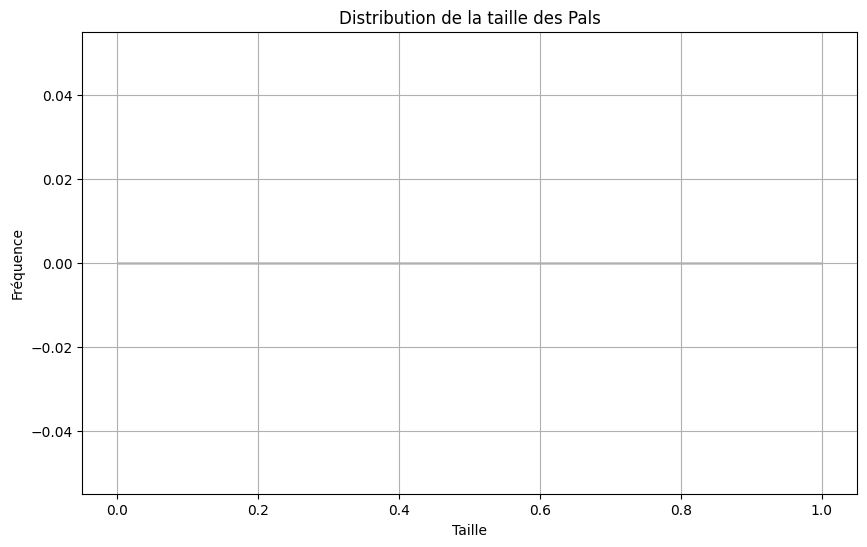

In [80]:
import sqlite3
import matplotlib.pyplot as plt

# Connexion à la base de données SQLite
conn = sqlite3.connect('palworld.db')
cursor = conn.cursor()

# Exécuter une requête SQL pour obtenir la distribution de la taille des Pals
cursor.execute('''
    SELECT "Volume size"
    FROM combat_attribute
    WHERE "Volume size" IS NOT NULL
''')
size_data = cursor.fetchall()

# Afficher une partie des données pour vérification
print("Sample size data:", size_data[:10])

# Convertir les données en une liste de tailles
sizes = [float(size[0]) for size in size_data if size[0].replace('.', '', 1).isdigit()]

# Afficher les tailles pour vérification
print("Sample sizes:", sizes[:10])

# Créer un histogramme de la distribution de la taille des Pals
plt.figure(figsize=(10, 6))
plt.hist(sizes, bins=20, edgecolor='black')
plt.title('Distribution de la taille des Pals')
plt.xlabel('Taille')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

conn.close()